# Cloudy predictions for ALMA proposals <a class="anchor" id="toc"></a>

1. [Barchiesi ALMA C9 proposal](#barchiesiC9)
2. [Salvestrini ALMA C9 proposal](#salvestriniC9)

In [4]:
# libraries
import os
import re, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from matplotlib import cm
from progressbar import ProgressBar

# useful constants
nan = np.nan
c = 2.99792458e10 #cm/s
pc = 3.086e18 # cm
msun = 1.99e33 # g
lsun = 3.9e33 # erg/s
ry_ev = 13.605698 # eV in 1 Rydberg
ry_nm = 91.1270 # nm in 1 Rydberg
ry_hz = 3.2898e+15 # Hz in 1 Rydberg
co_ghz = np.array([115.27, 230.54, 345.80, 461.04, 576.27, 691.47, 
                   806.65, 921.80, 1036.91, 1151.99, 1267.01, 1381.96, 1496.92])
co_mm = 2.9979e2 / co_ghz

# seaborn options
sns.set(rc={"figure.dpi":130, 'savefig.dpi':130})
sns.set_style('ticks')
sns.set_style({'xtick.direction': 'in', 'ytick.direction': 'in',
              'xtick.top': True, 'ytick.right': True})
sns.set_context("paper", rc={"font.size":14, 
                             "axes.titlesize":16, "axes.labelsize":16,
                             'xtick.labelsize':14, 'ytick.labelsize':14, 
                             'xtick.minor.size': 0, 'ytick.minor.size': 0})

# dataframes
llab = pd.read_csv('/media/phd/cloudy/database/line_labels_long.csv', index_col='label')
emili = pd.read_csv('/media/phd/cloudy/ngmgrid/emis_lines.csv', index_col='Name')

# useful functions
def ovrpdr(wd, filename):
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    ovr = pd.read_csv(wd + subdir + filename + '.ovr', sep='\t')
    pdr = pd.read_csv(wd + subdir + filename + '.pdr', sep='\t')
    return ovr, pdr

def emis(wd, filename):
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    emis = pd.read_csv(wd + subdir + filename + '.emis', sep='\t')
    return emis

def cosled(wd, filename, Jmax=30, norm=False):
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    emis = pd.read_csv(wd + subdir + filename + '.emis', sep='\t')
    colist = emis.columns.to_list()[1:31]
    Y = emis[colist[:Jmax]].iloc[-1].to_numpy()
    if norm: Y = Y / Y[0]
    return Y

def hcnsled(wd, filename, Jmax=8, norm=False):
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    emis = pd.read_csv(wd + subdir + filename + '.emis', sep='\t')
    hcnlist = emis.columns[emis.columns.str.contains('HCN')].to_list()
    Y = emis[hcnlist[:Jmax]].iloc[-1].to_numpy()
    if norm: Y = Y / Y[0]
    return Y

def hcosled(wd, filename, Jmax=8, norm=False):
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    emis = pd.read_csv(wd + subdir + filename + '.emis', sep='\t')
    hcnlist = emis.columns[emis.columns.str.contains('HCO+')].to_list()
    Y = emis[hcnlist[:Jmax]].iloc[-1].to_numpy()
    if norm: Y = Y / Y[0]
    return Y

def hncsled(wd, filename, Jmax=8, norm=False):
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    emis = pd.read_csv(wd + subdir + filename + '.emis', sep='\t')
    hcnlist = emis.columns[emis.columns.str.contains('HNC')].to_list()
    Y = emis[hcnlist[:Jmax]].iloc[-1].to_numpy()
    if norm: Y = Y / Y[0]
    return Y

def Csled(wd, filename, Jmax=3, norm=False):
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    emis = pd.read_csv(wd + subdir + filename + '.emis', sep='\t')
    Clist = emis.columns[emis.columns.str.startswith('C  ')].to_list()
    Y = emis[Clist[:Jmax]].iloc[-1].to_numpy()
    if norm: Y = Y / Y[0]
    return Y

def lineNH(wd, filename, mol, J):
    subdir = '_'.join(filename.split('_', 2)[:2]) + '/'
    emis = pd.read_csv(wd + subdir + filename + '.emis', sep='\t')
    sled = emis.columns[emis.columns.str.startswith(mol)].to_list()
    return emis[sled[J]]

def linegrid(wd, l1, save=False):
    emili = pd.read_csv('/media/phd/cloudy/ngmgrid/emis_lines.csv', index_col='Name')
    l1lab = emili.loc[l1, 'line']
    hden, G0, FX = np.arange(1, 6.75, 0.25), np.arange(-2.8, 3.25, 0.25), np.arange(-1, 4.2, 0.25)
    pdr = pd.DataFrame(index=['h' + ('%.2f' % h).replace('.', '') for h in hden],
                        columns=['g' + ('%.2f' % (g + 2.8)).replace('.', '') for g in G0])
    xdr = pd.DataFrame(index=['h' + ('%.2f' % h).replace('.', '') for h in hden],
                        columns=['x' + ('%.2f' % x).replace('.', '') for x in FX])
    pbar = ProgressBar()
    for h in pbar(hden):
        hname = 'h' + ('%.2f' % h).replace('.', '')
        for g in G0:
            gname = 'g' + ('%.2f' % (g + 2.8)).replace('.', '')
            ff = 'pdr_' + hname + '_' + gname
            pdr.loc[hname, gname] = emis(wd, ff)[l1lab].iloc[-1]
        for x in FX:
            xname = 'x' + ('%.2f' % x).replace('.', '')
            ff = 'xdr_' + hname + '_' + xname
            xdr.loc[hname, xname] = emis(wd, ff)[l1lab].iloc[-1]
    if save:
        pdr.to_csv(wd + l1 + '_cgs_PDR.csv')
        xdr.to_csv(wd + l1 + '_cgs_XDR.csv')
    return pdr, xdr

def ratiogrid(wd, l1, l2, save=False):
    emili = pd.read_csv('/media/phd/cloudy/ngmgrid/emis_lines.csv', index_col='Name')
    l1lab, l2lab = emili.loc[[l1, l2], 'line']
    hden, G0, FX = np.arange(1, 6.75, 0.25), np.arange(-2.8, 3.25, 0.25), np.arange(-1, 4.2, 0.25)
    pdr = pd.DataFrame(index=['h' + ('%.2f' % h).replace('.', '') for h in hden],
                        columns=['g' + ('%.2f' % (g + 2.8)).replace('.', '') for g in G0])
    xdr = pd.DataFrame(index=['h' + ('%.2f' % h).replace('.', '') for h in hden],
                        columns=['x' + ('%.2f' % x).replace('.', '') for x in FX])
    pbar = ProgressBar()
    for h in pbar(hden):
        hname = 'h' + ('%.2f' % h).replace('.', '')
        for g in G0:
            gname = 'g' + ('%.2f' % (g + 2.8)).replace('.', '')
            ff = 'pdr_' + hname + '_' + gname
            pdr.loc[hname, gname] = emis(wd, ff)[l1lab].iloc[-1] / emis(wd, ff)[l2lab].iloc[-1]
        for x in FX:
            xname = 'x' + ('%.2f' % x).replace('.', '')
            ff = 'xdr_' + hname + '_' + xname
            xdr.loc[hname, xname] = emis(wd, ff)[l1lab].iloc[-1] / emis(wd, ff)[l2lab].iloc[-1]
    if save:
        pdr.to_csv(wd + l1 + '_' + l2 + '_ratio_PDR.csv')
        xdr.to_csv(wd + l1 + '_' + l2 + '_ratio_XDR.csv')
    return pdr, xdr

***

# Calculating the line ratios for Barchiesi ALMA C9 proposal <a class="anchor" id="barchiesiC9"></a>
([back to top](#toc))

In [118]:
wd = '/media/phd/cloudy/ngmgrid/'
co6cII_pdr, co6cII_xdr = ratiogrid(wd, 'CO6', 'C158', save=True)
co13cII_pdr, co13cII_xdr = ratiogrid(wd, 'CO13', 'C158', save=True)
co14cII_pdr, co14cII_xdr = ratiogrid(wd, 'CO14', 'C158', save=True)

## CO(6-5) / [CII]

In [245]:
wd = '/media/phd/cloudy/ngmgrid/'
nu1, nu2 = 691.47e9, 1.9005e12
co6cII_pdr = pd.read_csv(wd + 'CO6_C158_ratio_PDR.csv', index_col=0) * (nu2/nu1)**3
co6cII_xdr = pd.read_csv(wd + 'CO6_C158_ratio_XDR.csv', index_col=0) * (nu2/nu1)**3
hden, G0, FX = np.arange(1, 6.75, 0.25), np.arange(-2.8, 3.25, 0.25), np.arange(-1, 4.2, 0.25)

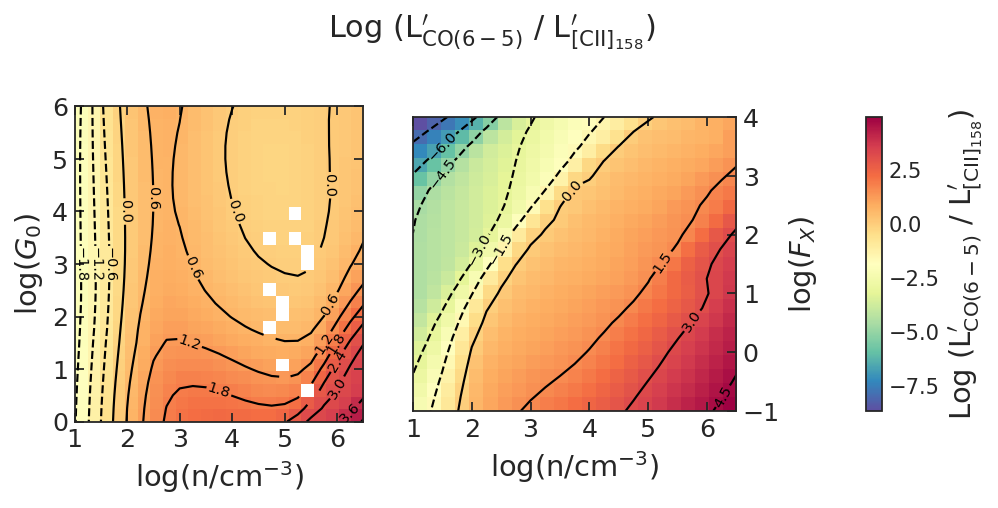

In [307]:
savefig=True

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(8,4))
vmin = np.min([np.log10(xdf.T).min().min() for xdf in [co6cII_pdr, co6cII_xdr]])
vmax = np.max([np.log10(xdf.T).max().max() for xdf in [co6cII_pdr, co6cII_xdr]])

# ax1=PDR
CP1 = ax1.contour(hden, G0+2.8, np.log10(co6cII_pdr.T), 10, colors='black')
ax1.clabel(CP1, inline=True, fontsize=8, colors='black')
im = ax1.imshow(np.log10(co6cII_pdr.T), vmin=vmin, vmax=vmax, cmap='Spectral_r',
          origin='lower', extent=[hden[0], hden[-1], G0[0]+2.8, G0[-1]+2.8])
ax1.set_ylabel(r'log($G_0$)')

# ax2=XDR
CP2 = ax2.contour(hden, FX, np.log10(co6cII_xdr.T), 10, colors='black')
ax2.clabel(CP2, inline=True, fontsize=8, colors='black')
im = ax2.imshow(np.log10(co6cII_xdr.T), vmin=vmin, vmax=vmax, cmap='Spectral_r',
          origin='lower', extent=[hden[0], hden[-1], FX[0], FX[-1]])
ax2.set_ylabel(r'log($F_X$)')
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()

# common options
for ax in [ax1, ax2]:
    ax.set_xlabel(r'log(n/cm$^{-3}$)')
    ax.set_xticks([1,2,3,4,5,6])
plt.suptitle(r'Log (L$^{\prime}_{\mathrm{CO}(6-5)}$ / L$^{\prime}_{[\mathrm{CII}]_{158}}$)');

cax = ax2.inset_axes([1.4, 0., 0.05, 1.], transform=ax2.transAxes)
cbar = plt.colorbar(im, ax=[ax1,ax2], cax=cax,
                    label=r'Log (L$^{\prime}_{\mathrm{CO}(6-5)}$ / L$^{\prime}_{[\mathrm{CII}]_{158}}$)')
cbar.ax.tick_params(labelsize='small')
plt.tight_layout();

if savefig: plt.savefig('./CO6_C158_ratio.png', dpi=300, bbox_inches='tight');

## CO(13-12) / [CII]

In [301]:
wd = '/media/phd/cloudy/ngmgrid/'
nu1, nu2 = 1496.92e9, 1.9005e12
co13cII_pdr = pd.read_csv(wd + 'CO13_C158_ratio_PDR.csv', index_col=0) * (nu2/nu1)**3
co13cII_xdr = pd.read_csv(wd + 'CO13_C158_ratio_XDR.csv', index_col=0) * (nu2/nu1)**3
hden, G0, FX = np.arange(1, 6.75, 0.25), np.arange(-2.8, 3.25, 0.25), np.arange(-1, 4.2, 0.25)

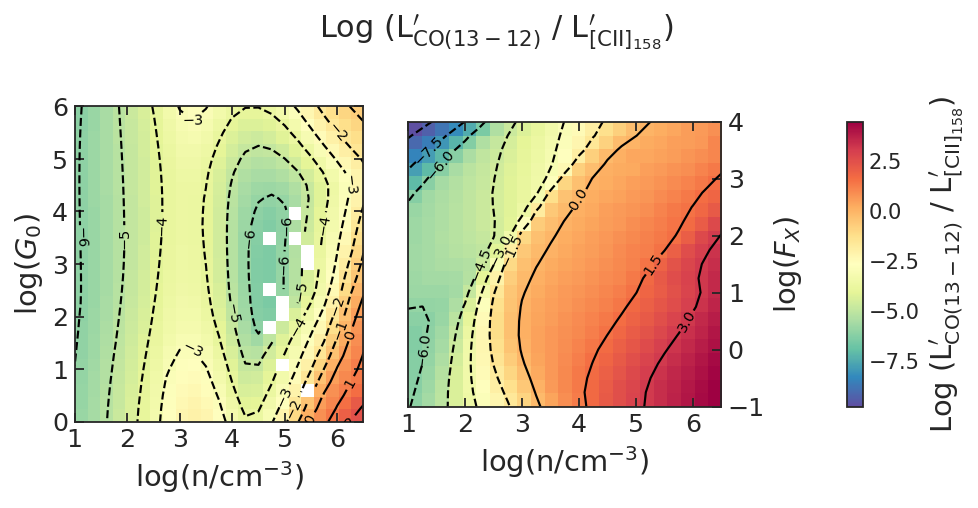

In [302]:
savefig=True

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(8,4))
vmin = np.min([np.log10(xdf.T).min().min() for xdf in [co13cII_pdr, co13cII_xdr]])
vmax = np.max([np.log10(xdf.T).max().max() for xdf in [co13cII_pdr, co13cII_xdr]])

# ax1=PDR
CP1 = ax1.contour(hden, G0+2.8, np.log10(co13cII_pdr.T), 10, colors='black')
ax1.clabel(CP1, inline=True, fontsize=8, colors='black')
im = ax1.imshow(np.log10(co13cII_pdr.T), vmin=vmin, vmax=vmax, cmap='Spectral_r',
          origin='lower', extent=[hden[0], hden[-1], G0[0]+2.8, G0[-1]+2.8])
ax1.set_ylabel(r'log($G_0$)')

# ax2=XDR
CP2 = ax2.contour(hden, FX, np.log10(co13cII_xdr.T), 10, colors='black')
ax2.clabel(CP2, inline=True, fontsize=8, colors='black')
im = ax2.imshow(np.log10(co13cII_xdr.T), vmin=vmin, vmax=vmax, cmap='Spectral_r',
          origin='lower', extent=[hden[0], hden[-1], FX[0], FX[-1]])
ax2.set_ylabel(r'log($F_X$)')
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()

# common options
for ax in [ax1, ax2]:
    ax.set_xlabel(r'log(n/cm$^{-3}$)')
    ax.set_xticks([1,2,3,4,5,6])
plt.suptitle(r'Log (L$^{\prime}_{\mathrm{CO}(13-12)}$ / L$^{\prime}_{[\mathrm{CII}]_{158}}$)');

cax = ax2.inset_axes([1.4, 0., 0.05, 1.], transform=ax2.transAxes)
cbar = plt.colorbar(im, ax=[ax1,ax2], cax=cax,
                    label=r'Log (L$^{\prime}_{\mathrm{CO}(13-12)}$ / L$^{\prime}_{[\mathrm{CII}]_{158}}$)')
cbar.ax.tick_params(labelsize='small')
plt.tight_layout();

if savefig: plt.savefig('./CO13_C158_ratio.png', dpi=300, bbox_inches='tight');

## CO(14-13) / [CII]

In [304]:
wd = '/media/phd/cloudy/ngmgrid/'
nu1, nu2 = 1611.79e9, 1.9005e12
co14cII_pdr = pd.read_csv(wd + 'CO14_C158_ratio_PDR.csv', index_col=0) * (nu2/nu1)**3
co14cII_xdr = pd.read_csv(wd + 'CO14_C158_ratio_XDR.csv', index_col=0) * (nu2/nu1)**3
hden, G0, FX = np.arange(1, 6.75, 0.25), np.arange(-2.8, 3.25, 0.25), np.arange(-1, 4.2, 0.25)

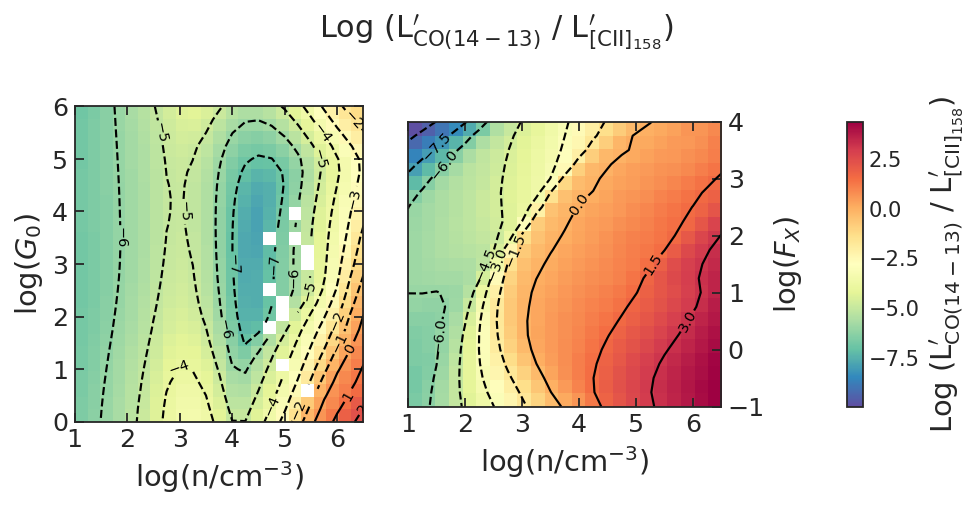

In [306]:
savefig=True

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(8,4))
vmin = np.min([np.log10(xdf.T).min().min() for xdf in [co14cII_pdr, co14cII_xdr]])
vmax = np.max([np.log10(xdf.T).max().max() for xdf in [co14cII_pdr, co14cII_xdr]])

# ax1=PDR
CP1 = ax1.contour(hden, G0+2.8, np.log10(co14cII_pdr.T), 10, colors='black')
ax1.clabel(CP1, inline=True, fontsize=8, colors='black')
im = ax1.imshow(np.log10(co14cII_pdr.T), vmin=vmin, vmax=vmax, cmap='Spectral_r',
          origin='lower', extent=[hden[0], hden[-1], G0[0]+2.8, G0[-1]+2.8])
ax1.set_ylabel(r'log($G_0$)')

# ax2=XDR
CP2 = ax2.contour(hden, FX, np.log10(co14cII_xdr.T), 10, colors='black')
ax2.clabel(CP2, inline=True, fontsize=8, colors='black')
im = ax2.imshow(np.log10(co14cII_xdr.T), vmin=vmin, vmax=vmax, cmap='Spectral_r',
          origin='lower', extent=[hden[0], hden[-1], FX[0], FX[-1]])
ax2.set_ylabel(r'log($F_X$)')
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()

# common options
for ax in [ax1, ax2]:
    ax.set_xlabel(r'log(n/cm$^{-3}$)')
    ax.set_xticks([1,2,3,4,5,6])
plt.suptitle(r'Log (L$^{\prime}_{\mathrm{CO}(14-13)}$ / L$^{\prime}_{[\mathrm{CII}]_{158}}$)');

cax = ax2.inset_axes([1.4, 0., 0.05, 1.], transform=ax2.transAxes)
cbar = plt.colorbar(im, ax=[ax1,ax2], cax=cax,
                    label=r'Log (L$^{\prime}_{\mathrm{CO}(14-13)}$ / L$^{\prime}_{[\mathrm{CII}]_{158}}$)')
cbar.ax.tick_params(labelsize='small')
plt.tight_layout();

if savefig: plt.savefig('./CO14_C158_ratio.png', dpi=300, bbox_inches='tight');

***

# Calculating the line ratios for Salvestrini ALMA C9 proposal <a class="anchor" id="salvestriniC9"></a>
([back to top](#toc))

In [22]:
print(emili[emili.index.str.startswith('HCN')])
print(emili[emili.index.str.startswith('HCO')])

               line
Name               
HCN1  HCN  3381.52m
HCN2  HCN  1690.78m
HCN3  HCN  1127.22m
HCN4  HCN  845.428m
HCN5  HCN  676.373m
HCN6  HCN  563.665m
HCN7  HCN  483.168m
HCN8  HCN  422.796m
                line
Name                
HCO+1  HCO+ 3360.43m
HCO+2  HCO+ 1680.21m
HCO+3  HCO+ 1120.18m
HCO+4  HCO+ 840.150m
HCO+5  HCO+ 672.144m
HCO+6  HCO+ 560.140m
HCO+7  HCO+ 480.147m
HCO+8  HCO+ 420.151m


In [17]:
wd = '/media/phd/cloudy/ngmgrid/'
l1, l2 = 'HCN2', 'HCO+2'
hcnhco21_pdr, hcnhco21_xdr = ratiogrid(wd, l1, l2, save=True)

100% |#########################################################################|


## HCN(2-1) / HCO$^+$(2-1)

In [3]:
wd = '/media/phd/cloudy/ngmgrid/'
l1, l2 = 'HCN2', 'HCO+2'
lambda1, lambda2 = 1690.78, 1680.21
hcnhco21_pdr = pd.read_csv(wd + l1 + '_' + l2 + '_ratio_PDR.csv', index_col=0)# * (lambda1/lambda2)**3
hcnhco21_xdr = pd.read_csv(wd + l1 + '_' + l2 + '_ratio_XDR.csv', index_col=0)# * (lambda1/lambda2)**3
hden, G0, FX = np.arange(1, 6.75, 0.25), np.arange(-2.8, 3.25, 0.25), np.arange(-1, 4.2, 0.25)

/tmp/ipykernel_7673/1925188479.py:3: RuntimeWarning: divide by zero encountered in log10
  PDR, XDR = np.log10(hcnhco21_pdr.T), np.log10(hcnhco21_xdr.T)


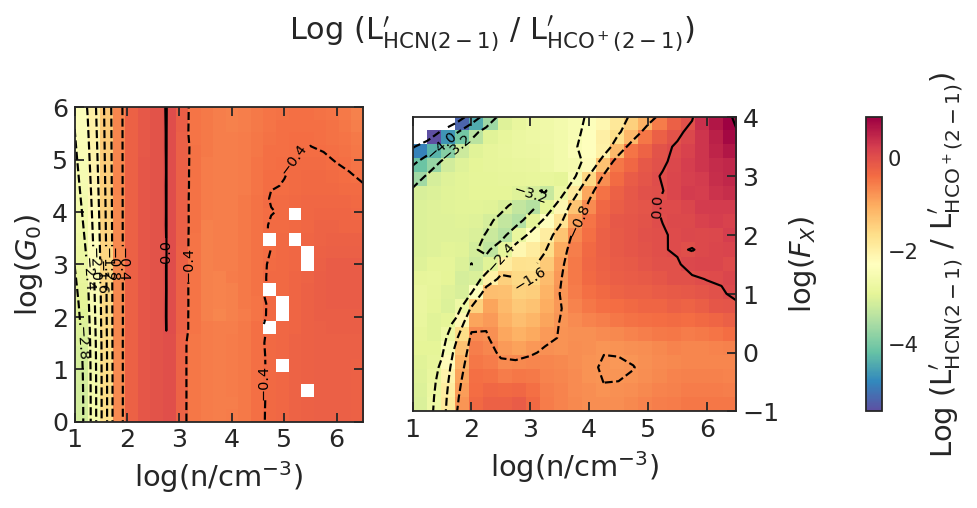

In [3]:
savefig=False

PDR, XDR = np.log10(hcnhco21_pdr.T), np.log10(hcnhco21_xdr.T)
titolo = r'Log (L$^{\prime}_{\mathrm{HCN}(2-1)}$ / L$^{\prime}_{\mathrm{HCO}^+(2-1)}$)'

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(8,4))
vmin = np.min([xdf[np.isfinite(xdf)].min().min() for xdf in [PDR, XDR]])
vmax = np.max([xdf[np.isfinite(xdf)].max().max() for xdf in [PDR, XDR]])

# ax1=PDR
CP1 = ax1.contour(hden, G0+2.8, PDR, levels=7, colors='black')
ax1.clabel(CP1, inline=True, fontsize=8, colors='black')
im = ax1.imshow(PDR, vmin=vmin, vmax=vmax, cmap='Spectral_r',
          origin='lower', extent=[hden[0], hden[-1], G0[0]+2.8, G0[-1]+2.8])
ax1.set_ylabel(r'log($G_0$)')

# ax2=XDR
CP2 = ax2.contour(hden, FX, XDR, levels=7, colors='black')
ax2.clabel(CP2, inline=True, fontsize=8, colors='black')
im = ax2.imshow(XDR, vmin=vmin, vmax=vmax, cmap='Spectral_r',
          origin='lower', extent=[hden[0], hden[-1], FX[0], FX[-1]])
ax2.set_ylabel(r'log($F_X$)')
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()

# common options
for ax in [ax1, ax2]:
    ax.set_xlabel(r'log(n/cm$^{-3}$)')
    ax.set_xticks([1,2,3,4,5,6])
plt.suptitle(titolo);

cax = ax2.inset_axes([1.4, 0., 0.05, 1.], transform=ax2.transAxes)
cbar = plt.colorbar(im, ax=[ax1,ax2], cax=cax, label=titolo)
cbar.ax.tick_params(labelsize='small')
plt.tight_layout();

if savefig: plt.savefig('./' + l1 + '_' + l2 + '_ratio.png', dpi=300, bbox_inches='tight');

Let's check the absolute values instead of the line ratios

In [5]:
wd = '/media/phd/cloudy/ngmgrid/'
l1, l2 = 'HCN2', 'HCO+2'
hcn21_pdr, hcn21_xdr = linegrid(wd, l1, save=True)
hco21_pdr, hco21_xdr = linegrid(wd, l2, save=True)

100% |#########################################################################|
100% |#########################################################################|


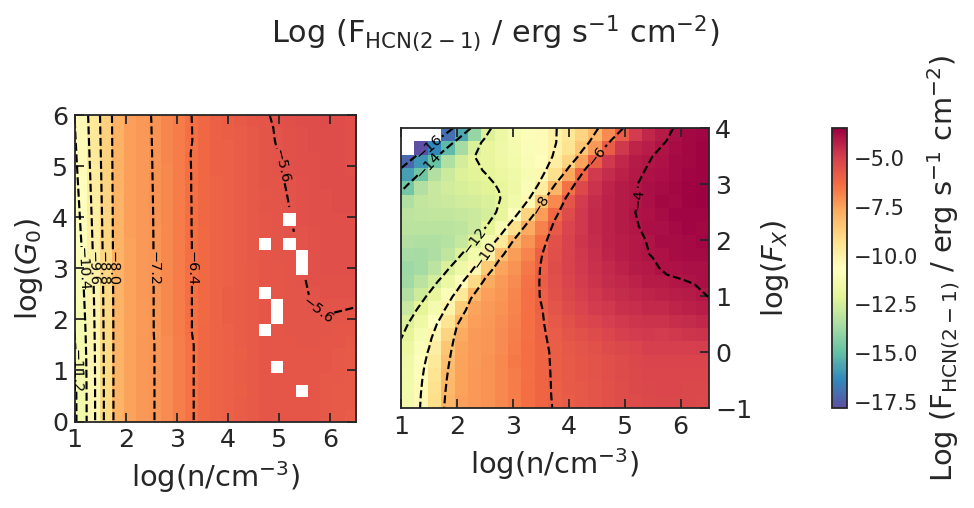

In [20]:
savefig=True

ll = 'HCN2'
PDR, XDR = np.log10(hcn21_pdr.T.replace(0, np.nan)), np.log10(hcn21_xdr.T.replace(0, np.nan))
titolo = r'Log (F$_{\mathrm{HCN}(2-1)}$ / erg s$^{-1}$ cm$^{-2}$)'

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(8,4))
vmin = np.min([xdf[np.isfinite(xdf)].min().min() for xdf in [PDR, XDR]])
vmax = np.max([xdf[np.isfinite(xdf)].max().max() for xdf in [PDR, XDR]])

# ax1=PDR
CP1 = ax1.contour(hden, G0+2.8, PDR, levels=7, colors='black')
ax1.clabel(CP1, inline=True, fontsize=8, colors='black')
im = ax1.imshow(PDR, vmin=vmin, vmax=vmax, cmap='Spectral_r',
          origin='lower', extent=[hden[0], hden[-1], G0[0]+2.8, G0[-1]+2.8])
ax1.set_ylabel(r'log($G_0$)')

# ax2=XDR
CP2 = ax2.contour(hden, FX, XDR, levels=7, colors='black')
ax2.clabel(CP2, inline=True, fontsize=8, colors='black')
im = ax2.imshow(XDR, vmin=vmin, vmax=vmax, cmap='Spectral_r',
          origin='lower', extent=[hden[0], hden[-1], FX[0], FX[-1]])
ax2.set_ylabel(r'log($F_X$)')
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()

# common options
for ax in [ax1, ax2]:
    ax.set_xlabel(r'log(n/cm$^{-3}$)')
    ax.set_xticks([1,2,3,4,5,6])
plt.suptitle(titolo);

cax = ax2.inset_axes([1.4, 0., 0.05, 1.], transform=ax2.transAxes)
cbar = plt.colorbar(im, ax=[ax1,ax2], cax=cax, label=titolo)
cbar.ax.tick_params(labelsize='small')
plt.tight_layout();

if savefig: plt.savefig('./' + ll + '_cgs.png', dpi=300, bbox_inches='tight');

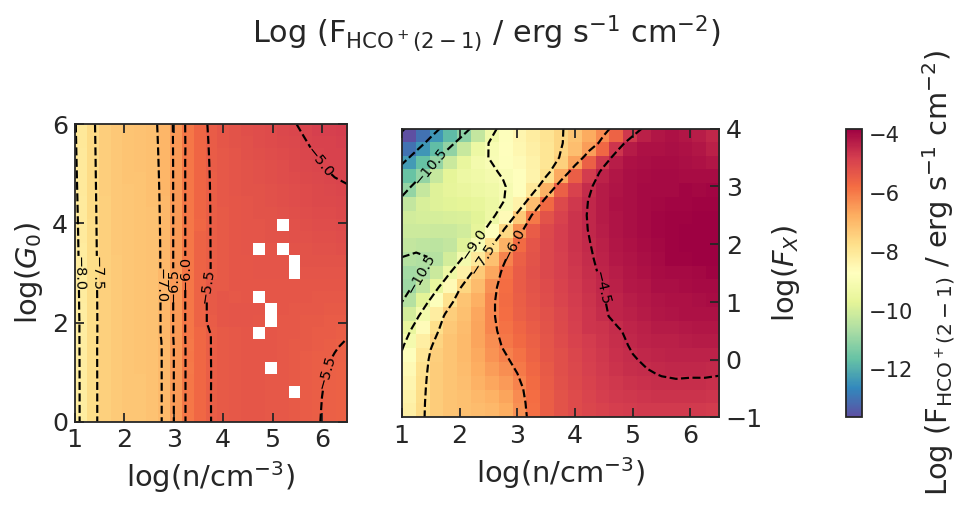

In [21]:
savefig=True

ll = 'HCO+2'
PDR, XDR = np.log10(hco21_pdr.T.replace(0, np.nan)), np.log10(hco21_xdr.T.replace(0, np.nan))
titolo = r'Log (F$_{\mathrm{HCO}^+(2-1)}$ / erg s$^{-1}$ cm$^{-2}$)'

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(8,4))
vmin = np.min([xdf[np.isfinite(xdf)].min().min() for xdf in [PDR, XDR]])
vmax = np.max([xdf[np.isfinite(xdf)].max().max() for xdf in [PDR, XDR]])

# ax1=PDR
CP1 = ax1.contour(hden, G0+2.8, PDR, levels=7, colors='black')
ax1.clabel(CP1, inline=True, fontsize=8, colors='black')
im = ax1.imshow(PDR, vmin=vmin, vmax=vmax, cmap='Spectral_r',
          origin='lower', extent=[hden[0], hden[-1], G0[0]+2.8, G0[-1]+2.8])
ax1.set_ylabel(r'log($G_0$)')

# ax2=XDR
CP2 = ax2.contour(hden, FX, XDR, levels=7, colors='black')
ax2.clabel(CP2, inline=True, fontsize=8, colors='black')
im = ax2.imshow(XDR, vmin=vmin, vmax=vmax, cmap='Spectral_r',
          origin='lower', extent=[hden[0], hden[-1], FX[0], FX[-1]])
ax2.set_ylabel(r'log($F_X$)')
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()

# common options
for ax in [ax1, ax2]:
    ax.set_xlabel(r'log(n/cm$^{-3}$)')
    ax.set_xticks([1,2,3,4,5,6])
plt.suptitle(titolo);

cax = ax2.inset_axes([1.4, 0., 0.05, 1.], transform=ax2.transAxes)
cbar = plt.colorbar(im, ax=[ax1,ax2], cax=cax, label=titolo)
cbar.ax.tick_params(labelsize='small')
plt.tight_layout();

if savefig: plt.savefig('./' + ll + '_cgs.png', dpi=300, bbox_inches='tight');